<a href="https://colab.research.google.com/github/MadsNL/AMLMain/blob/Mads/vis_AML_IceCores_combined_train_on_everything_resnetstuff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! gdown --id 1paSsYReykEVDPX8pA2SUf7Gr7Lptq-PX
! unzip Insoluables_TrainingData26May2022.zip
!git clone https://github.com/MadsNL/AMLpackages.git
import sys
sys.path.append('/content/AMLpackages/')
from load_data import training_set, not_training_set
from load_data import training_set_RGB
from Models import make_autoencoder
!pip install pyyaml h5py 
!pip install umap-learn

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1paSsYReykEVDPX8pA2SUf7Gr7Lptq-PX
To: /content/Insoluables_TrainingData26May2022.zip
100% 726M/726M [00:03<00:00, 227MB/s]
Archive:  Insoluables_TrainingData26May2022.zip
replace Insoluables_TrainingData/train/camp.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
#import umap
import seaborn as sb
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [ ]:
sup_path = '/content/Insoluables_TrainingData/train/'
sup_im_path = '/content/Insoluables_TrainingData/train/'
sup_df = pd.read_csv(sup_path+'train.csv')
train_df, test_df = train_test_split(sup_df, test_size=0.2, random_state=37)
train = training_set_RGB(train_df, sup_im_path)
test = training_set_RGB(test_df, sup_im_path)

In [ ]:
# save image_size
im_e, _, _ = train.__getitem__(0)
image_size = im_e.shape[0]
image_size

128

In [ ]:
train_size = len(train.labels)
test_size = len(test.labels)

In [ ]:
def make_NN_conv():
  image_size = 128

  conv_input = keras.Input(shape=(image_size,image_size,3))
  x = ResNet50(input_shape=(image_size, image_size,3), include_top=False, weights='imagenet', pooling='max')(conv_input)
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
  x = keras.layers.Dense(128, activation='relu')(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
  conv_output = keras.layers.Dense(128)(x)

  meta_input = keras.Input(shape=(34))
  x = keras.layers.Dense(128, activation='relu')(meta_input)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
  x = keras.layers.Dense(64, activation='relu')(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
  meta_output = keras.layers.Dense(32, activation='relu')(x)

  combined = keras.layers.concatenate([conv_output, meta_output])

  x = keras.layers.Dense(96, activation='relu')(combined)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
  x = keras.layers.Dense(40, activation='relu')(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
  combined_output = keras.layers.Dense(7, activation='softmax')(x)

  model = keras.Model([conv_input, meta_input], combined_output)

  model.summary()

  opt = keras.optimizers.Adam(lr=0.001, decay=1e-6)

  model.compile(opt, loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

  return model

In [ ]:
NN = make_NN_conv()

94781440/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 2048)         23587712    ['input_1[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 flatten (Flatten)           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
from keras.utils.vis_utils import plot_model

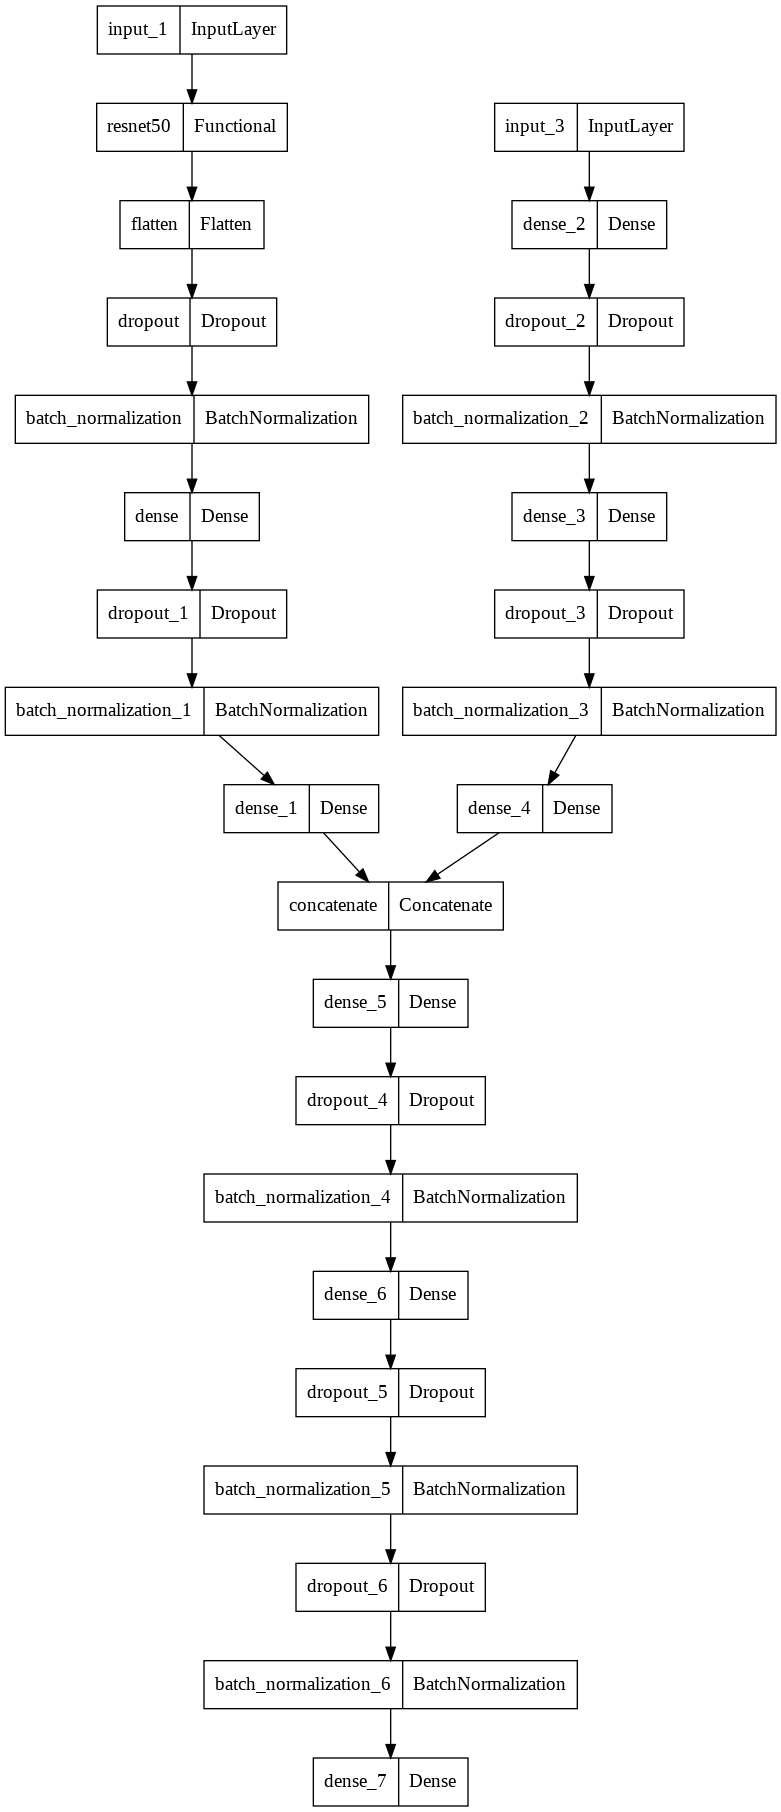

In [ ]:
plot_model(NN)

In [ ]:
train_increment = 5000
#nr_trains = train_size//train_increment
nr_trains=1
points_left_over = train_size % train_increment

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

index_count = 0
for i in range(nr_trains):
  x_im = []
  x_lab = []
  x_feat = []
  for j in range(train_increment):
    im, lab, feat = train.__getitem__(index_count)
    index_count += 1
    x_im.append(im)
    x_lab.append(lab)
    x_feat.append(feat)

  x_im = np.array(x_im)
  x_lab = np.array(x_lab)
  x_feat = np.array(x_feat)

  NN.fit([x_im, x_feat], x_lab, epochs=200, batch_size=32, validation_split=0.1, callbacks=[callback])

Epoch 1/200
141/141 [==============================] - 19s 136ms/step - loss: 0.3728 - accuracy: 0.8713 - val_loss: 1.0206 - val_accuracy: 0.6040
Epoch 2/200
141/141 [==============================] - 19s 138ms/step - loss: 0.4055 - accuracy: 0.8600 - val_loss: 0.6344 - val_accuracy: 0.7660
Epoch 3/200
141/141 [==============================] - 19s 138ms/step - loss: 0.3481 - accuracy: 0.8844 - val_loss: 0.5887 - val_accuracy: 0.8100
Epoch 4/200
141/141 [==============================] - 19s 136ms/step - loss: 0.3511 - accuracy: 0.8811 - val_loss: 0.6138 - val_accuracy: 0.7940
Epoch 5/200
141/141 [==============================] - 19s 136ms/step - loss: 0.3067 - accuracy: 0.8967 - val_loss: 0.7111 - val_accuracy: 0.8040
Epoch 6/200
141/141 [==============================] - 19s 137ms/step - loss: 0.2748 - accuracy: 0.9069 - val_loss: 0.6924 - val_accuracy: 0.7940


In [ ]:
x_train = []
for i in range(points_left_over):
  im, _, _ = train.__getitem__(index_count)
  index_count += 1
  x_train.append(im)
x_train = np.array(x_train)
autoencoder.fit(x_train, x_train, epochs=200, batch_size=32, validation_split=0.1, callbacks=[callback])

NameError: ignored

In [ ]:
encoder.save('encoder_128_resnet')
autoencoder.save('autoencoder_128_resnet')

In [ ]:
!zip -r encoder_128_resnet.zip encoder_128_resnet/
!zip -r autoencoder_128_resnet.zip autoencoder_128_resnet/
from google.colab import files
files.download("encoder_128_resnet.zip")
files.download("autoencoder_128_resnet.zip")